# SPACEc: Cellular Neighborhood Analysis

## Set up environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# silencing warnings
import warnings
warnings.filterwarnings('ignore')

#import standard packages
import pathlib
import scanpy as sc

In [3]:
import spacec as sp

2024-01-18 08:40:03.534211: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mgbckr/miniconda3/envs/yuqi-spacodex/lib/python3.10/site-packages/cv2/../../lib64:
2024-01-18 08:40:03.534254: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
root_path = pathlib.Path("..")

data_path = root_path / 'data' # where the data is stored

# where you want to store the output
output_dir = root_path / '_out'
output_dir.mkdir(exist_ok=True, parents=True)

In [5]:
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [6]:
# Loading the denoise/filtered anndata from notebook 3 [cell type or cluster annotation is necessary for the step]
adata = sc.read(output_dir / 'adata_nn_demo_annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 49548 × 58
    obs: 'DAPI', 'x', 'y', 'area', 'region_num', 'region', 'unique_region', 'condition', 'leiden_0.4', 'leiden_0.4_subcluster_0', 'leiden_0.4_subcluster_3', 'leiden_0.4_subcluster_4', 'celltype', 'leiden_0.4_subcluster_2', 'leiden_0.4_subcluster_11', 'leiden_0.4_subcluster_0sub', 'celltype_fine'
    uns: 'celltype_fine_colors', 'dendrogram_leiden_0.4', 'dendrogram_leiden_0.4_subcluster_4', 'leiden', 'leiden_0.4_colors', 'leiden_0.4_subcluster_0sub_colors', 'leiden_0.4_subcluster_4_colors', 'neighbors', 'umap', 'unique_region_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

# 4.1 Compute for Cellular Neighborhoods

In [7]:
# compute for CNs
# tune k and n_neighborhoods to obtain the best result
adata = sp.tl.neighborhood_analysis_ad(
    adata, 
    unique_region = "unique_region", 
    cluster_col = "celltype_fine", 
    X = 'x', Y = 'y',
    k = 20, # k nearest neighbors
    n_neighborhoods = 6, #number of CNs
    elbow = False)

Starting: 2/2 : reg001
Finishing: 2/2 : reg001 1.376654863357544 1.377012014389038
Starting: 1/2 : reg010
Finishing: 1/2 : reg010 0.6227257251739502 2.0045418739318848


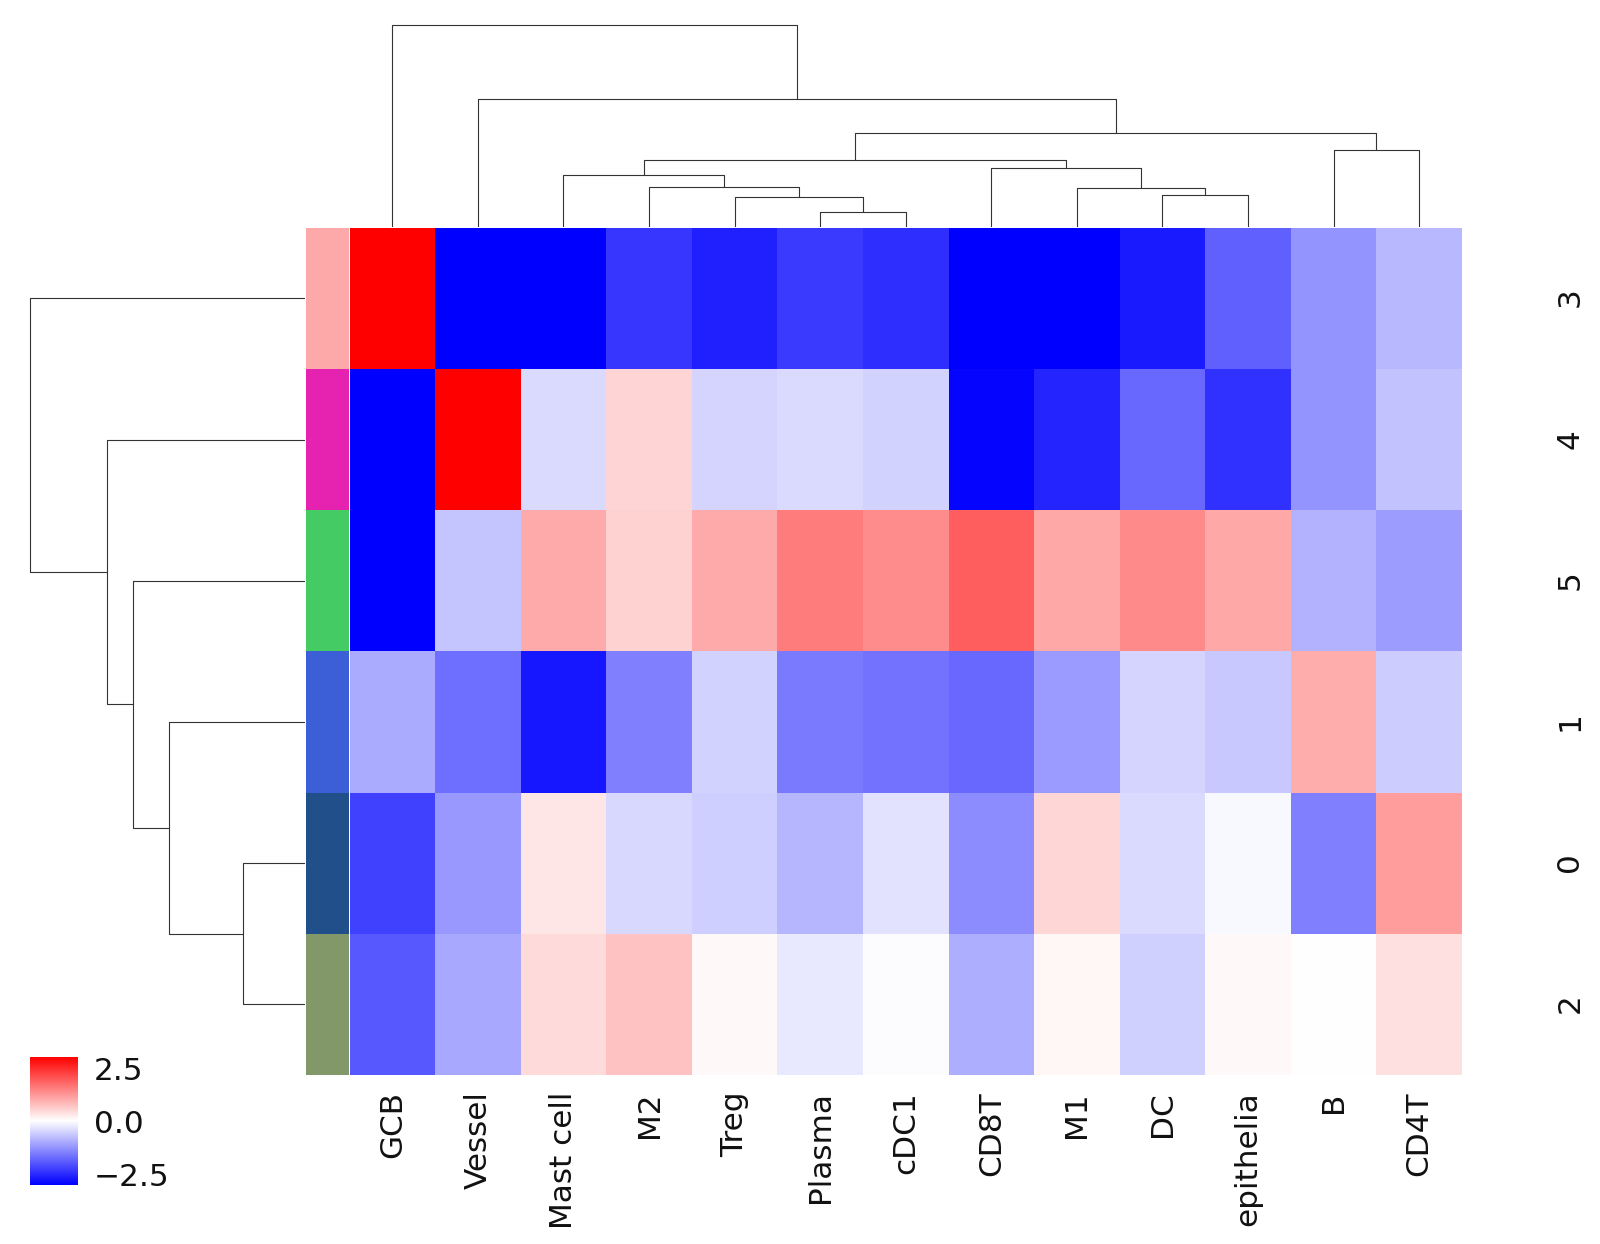

In [8]:
# to better visualize the cellular neighborhood (CN), we choose a color palette
# but if you set palette = None in the following function, it will randomly generate a palette for you
cn_palette = {
    0: '#204F89',
    1: '#3C5FD7',
    2: '#829868',
    3: '#FDA9AA',
    4: '#E623B1',
    5: '#44CB63'}

# plot CN to see what cell types are enriched per CN so that we can annotate them better
sp.pl.cn_exp_heatmap_ad(
    adata, 
    cluster_col = "celltype_fine",
    cn_col = "CN_k20_n6",
    palette=cn_palette,
    figsize=(10,8),
    savefig = False,
    output_dir = output_dir,
    rand_seed = 1
)

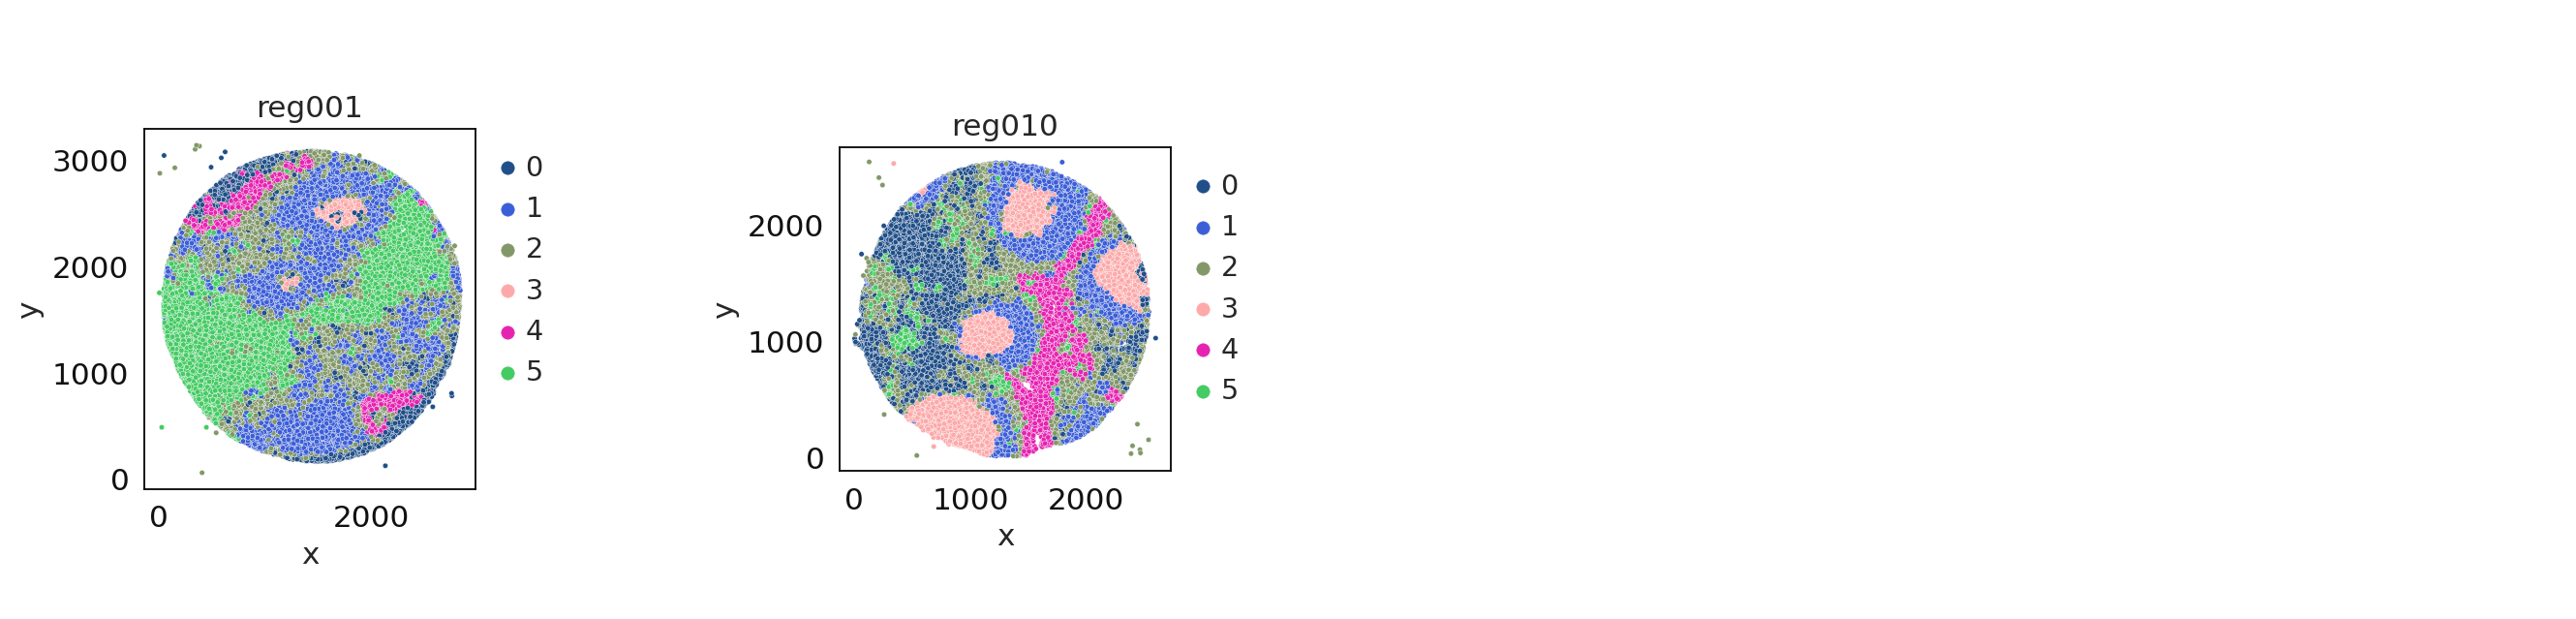

In [9]:
# plot the CN in the spatial coordinates, using the same color palette
sp.pl.catplot_ad(
    adata, 
    color = "CN_k20_n6", 
    unique_region = "unique_region",
    X='x', Y='y',
    palette= cn_palette, 
    savefig=False,
    output_dir=output_dir,
)

In [10]:
# Define neighborhood annotation for every cluster ID
neighborhood_annotation = {
    0: 'Immune Priming Zone',
    1: 'Parafollicular T cell Zone',
    2: 'Marginal Zone',
    3: 'Germinal center',
    4: 'Marginal Zone B-DC Enriched',# we dont have the DC markers to separate the inner pink from the outer pink; but they are both encountering immature B cells
    5: "Epithelium", 
}

adata.obs['CN_k20_n6_annot'] = (
    adata.obs['CN_k20_n6']
    .map(neighborhood_annotation)
    .astype('category')
)

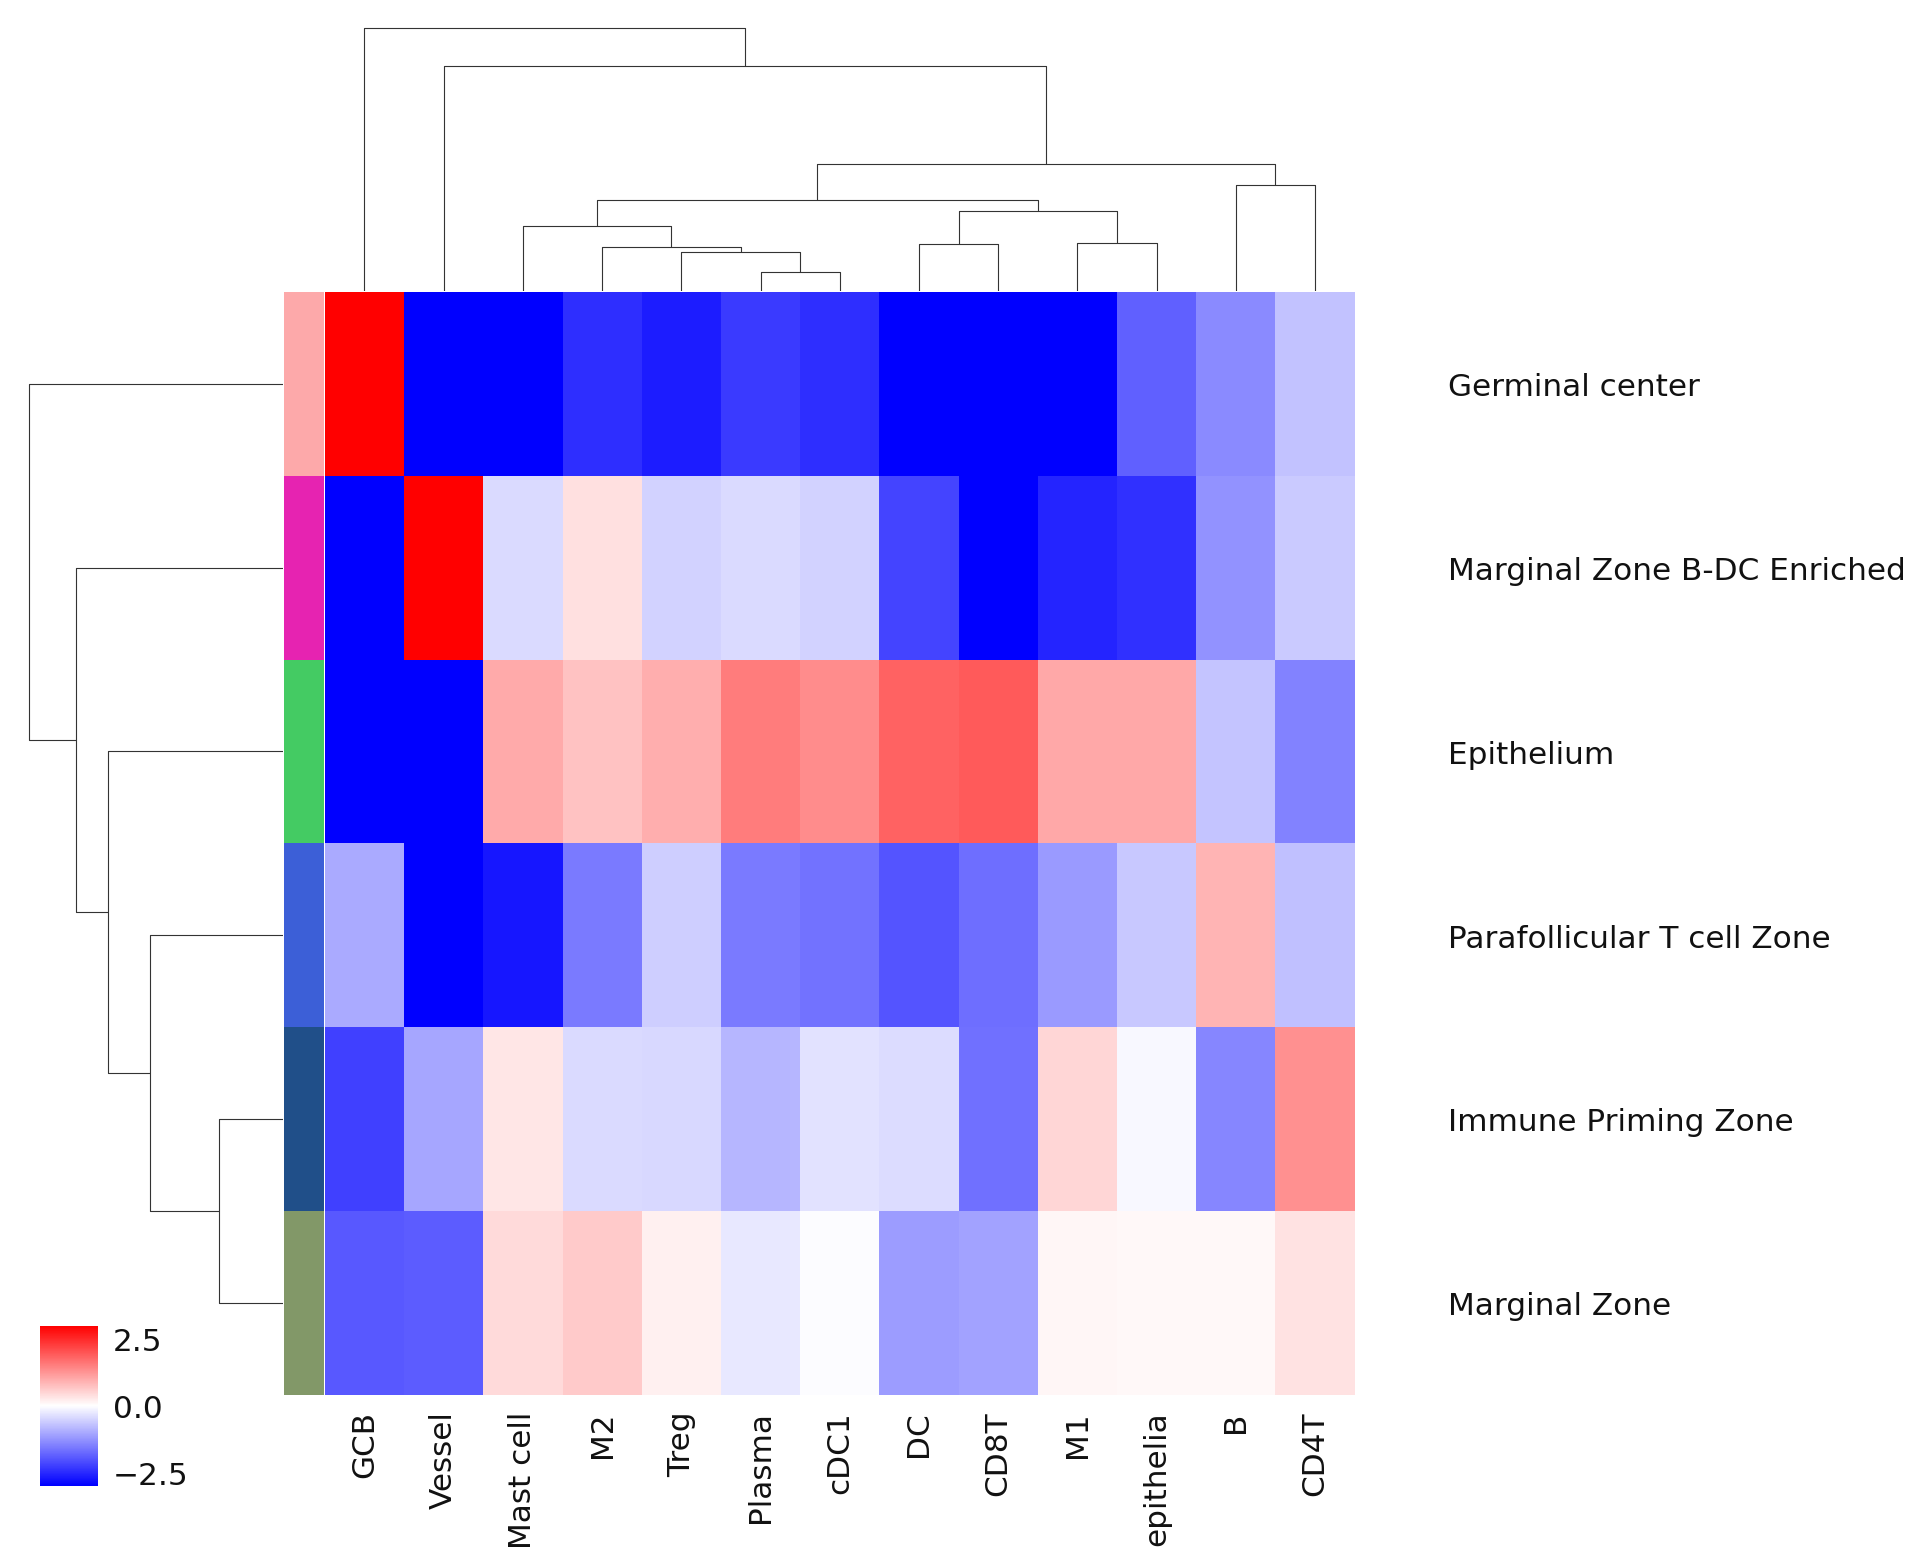

In [11]:
# match the color of the annotated CN to the original CN
cn_annt_palette = {neighborhood_annotation[key]: value for key, value in cn_palette.items()}

pass

# replotting with CN annotation
sp.pl.cn_exp_heatmap_ad(
    adata, 
    cluster_col = "celltype", 
    cn_col = "CN_k20_n6_annot",
    palette = cn_annt_palette, #if None, there is randomly generated in the code 
    savefig=True,
    figsize=(12,10),
    output_fname = "",
    output_dir = output_dir,
)



In [12]:
adata.write_h5ad(output_dir / 'adata_nn_demo_annotated_cn.h5ad')

## 4.2 Spatial context maps
To plot the spatial context between cellular neighborhoods or communities spatial context maps are a useful visualization. The analysis uses a similar sliding window approach as used for the detection of CNs/Communities but takes these broader groups as input. The resulting vectors are used to analyze which CNs/Communities tend to form interfaces. These interfaces are shown in the graph. Colored squares show single CNs or combinations of them, edges connect parent nodes with daughter nodes. The black circles indicate the abundance of cells falling into these spatial groups. 

In [13]:
# We will look at the spatial context maps sepataely for each condition
adata_tonsil = adata[adata.obs['condition'] == 'tonsil']
adata_tonsillitis = adata[adata.obs['condition'] == 'tonsillitis']

#### tonsil

Starting: 1/1 : 1
Finishing: 1/1 : 1 0.6063647270202637 0.6063714027404785
8 0.02477576826937211


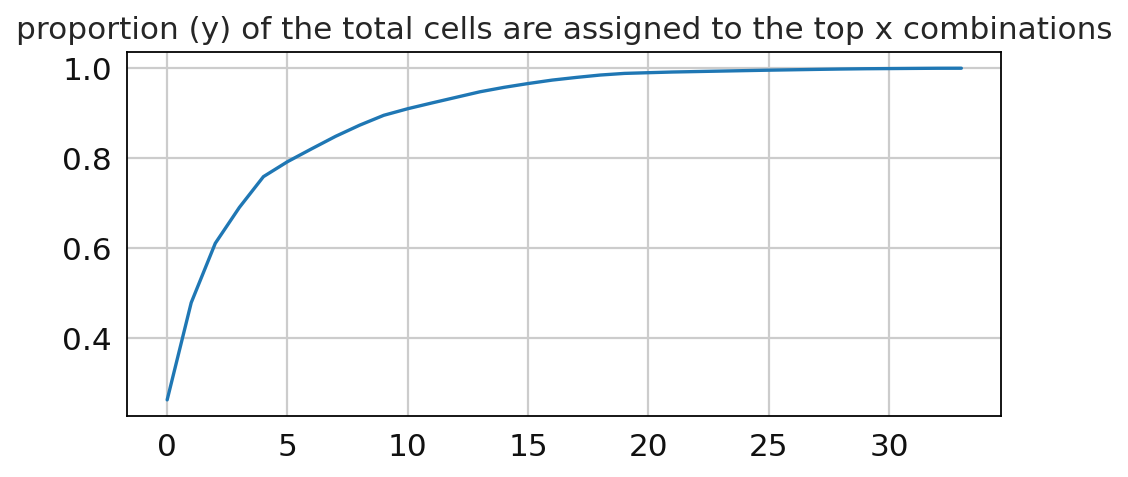

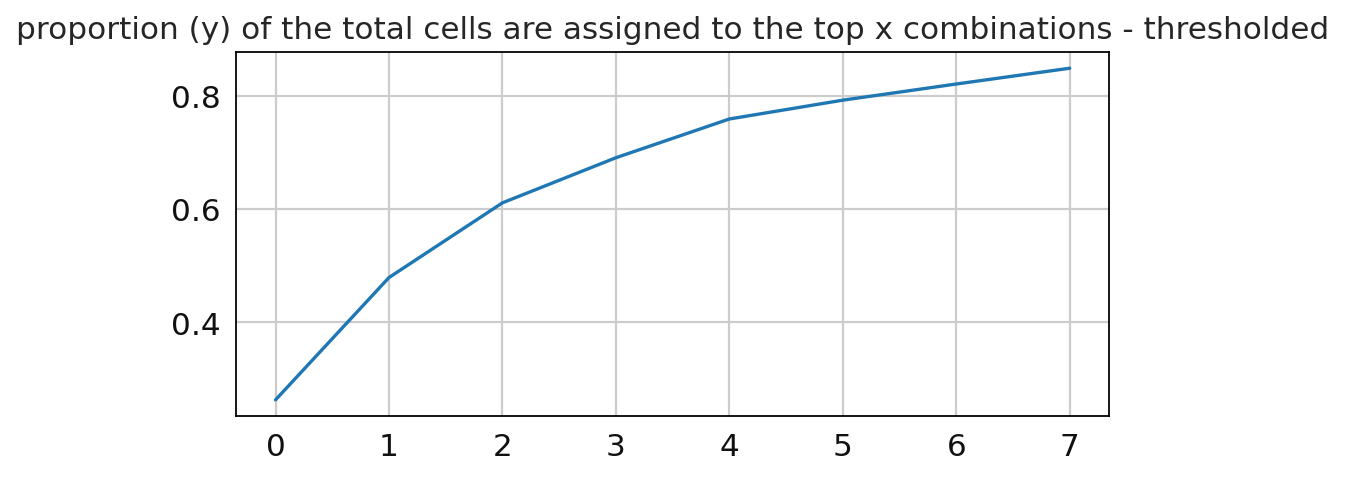

In [14]:
cnmap_dict_tonsil = sp.tl.cn_map_ad(
    adata = adata_tonsil, # adata object
    cn_col = "CN_k20_n6",# column with CNs
    palette = None, # color dictionary
    unique_region = 'region_num',# column with unique regions
    k = 70, # number of neighbors
    X='x', Y='y',  # coordinates
    threshold = 0.85, # threshold for percentage of cells in CN
    per_keep_thres = 0.85,) # threshold for percentage of cells in CN

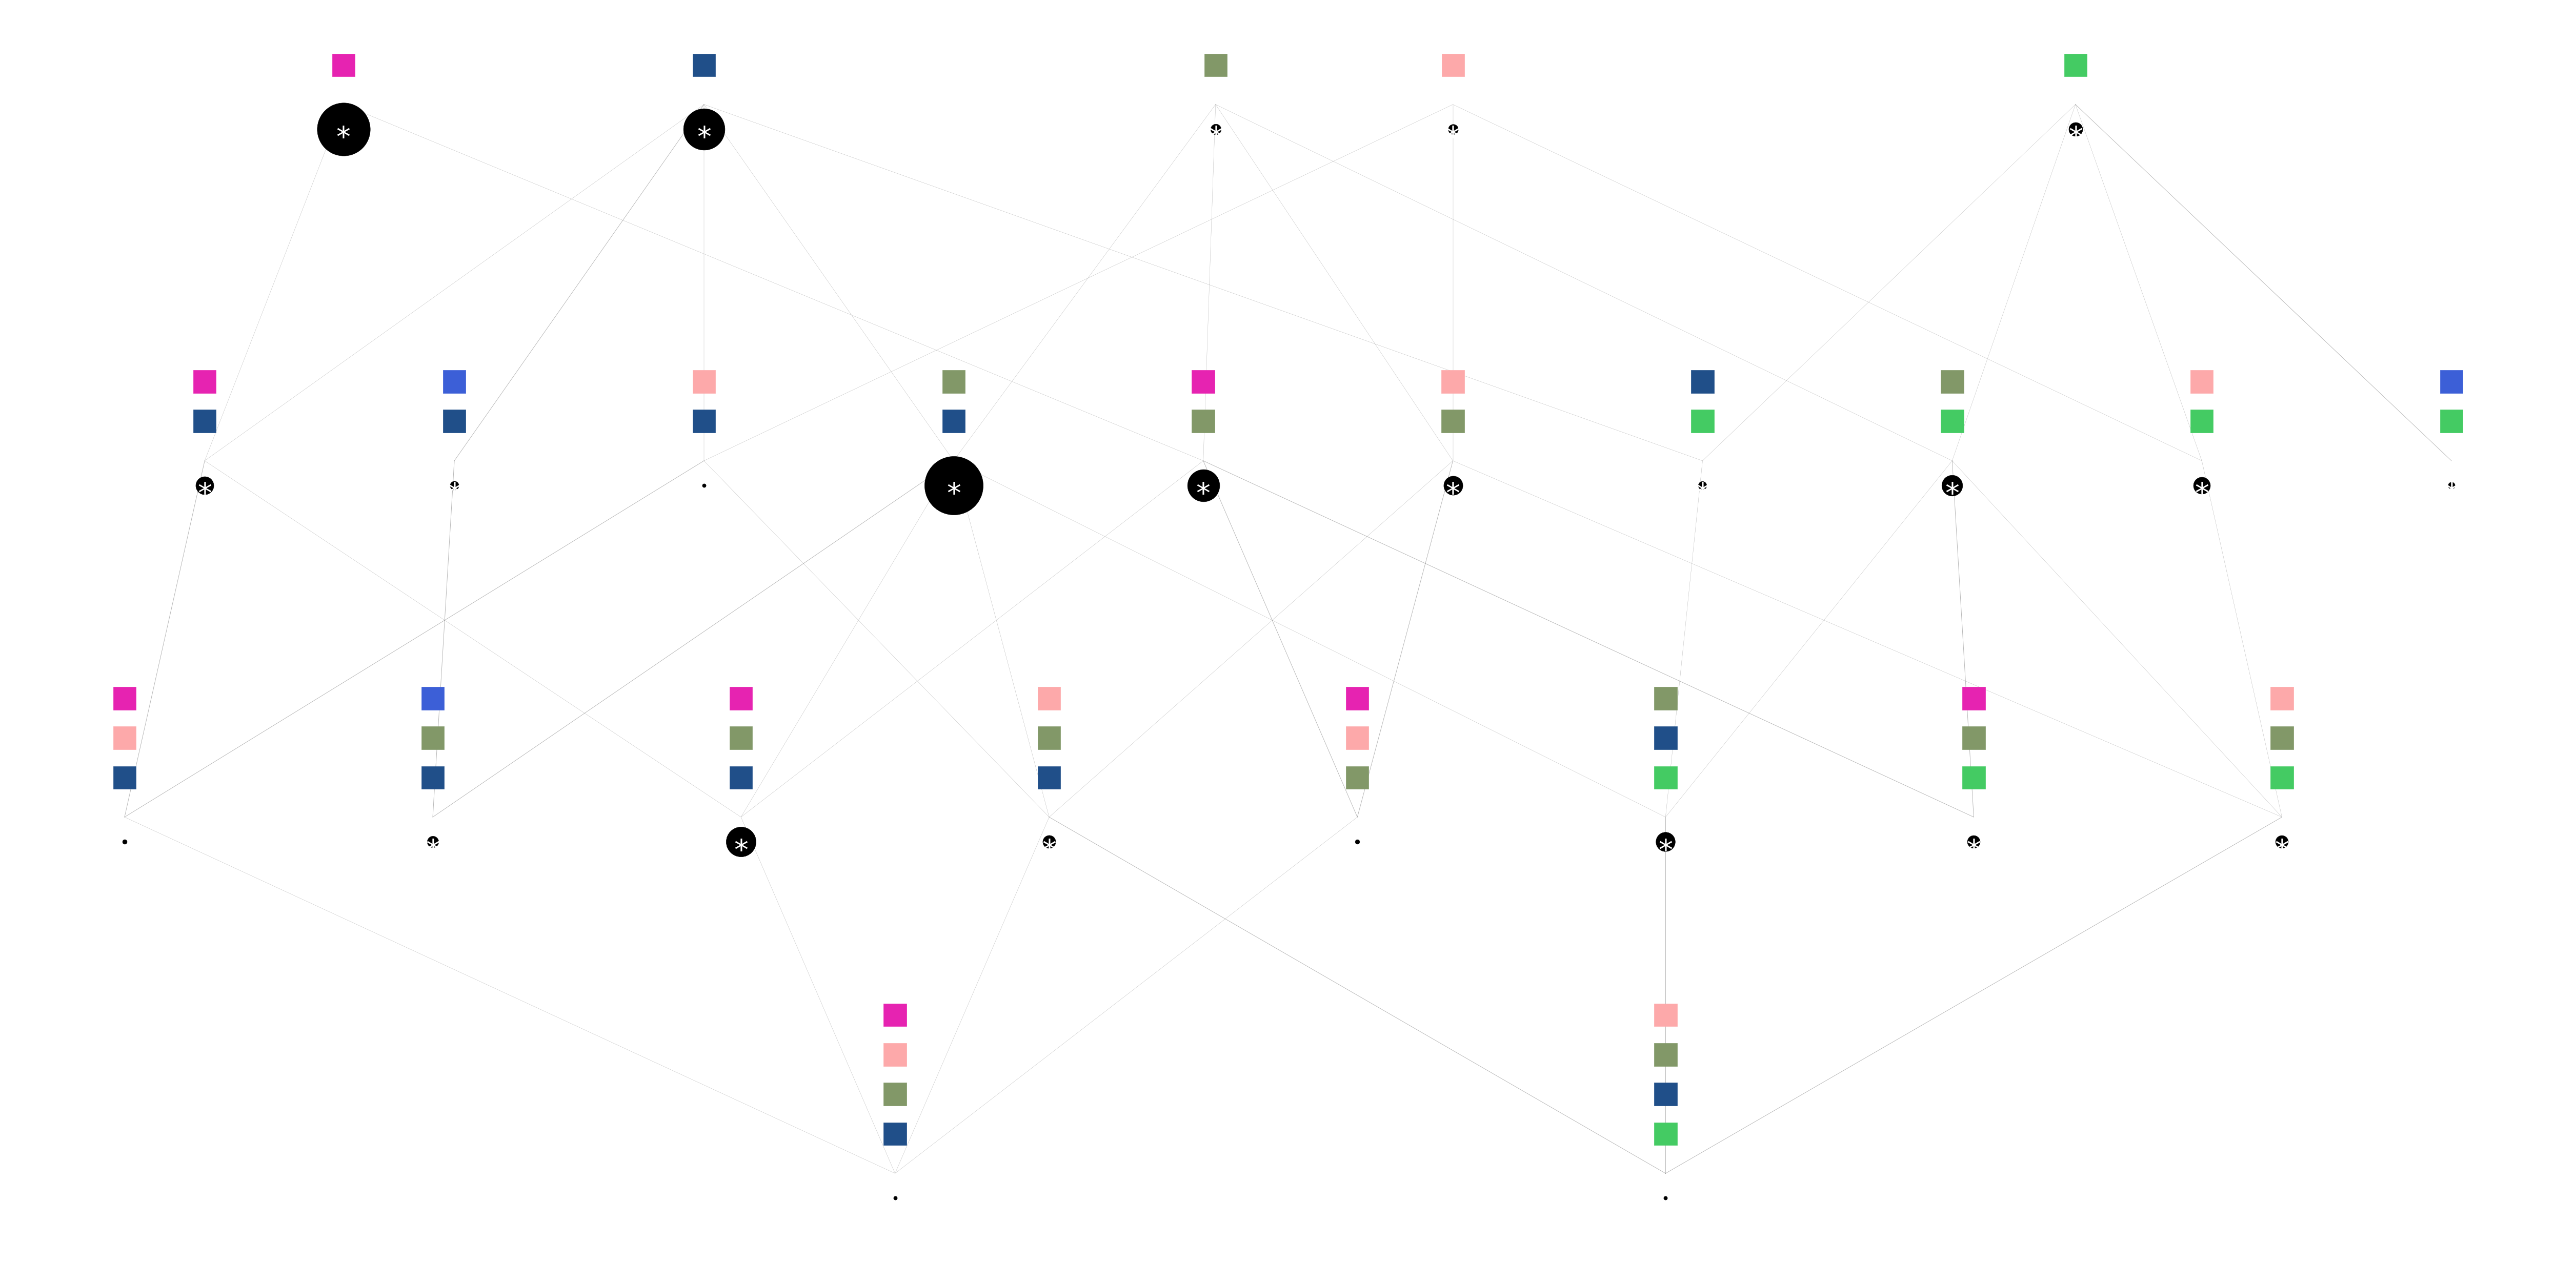

In [15]:
# Compute for the frequency of the CNs and paly around with the threshold
sp.pl.cn_map(cnmap_dict = cnmap_dict_tonsil,
         adata = adata_tonsil,
        cn_col = "CN_k20_n6",
        palette = None,
        figsize=(40, 20),
        savefig=False,
        output_fname = "",
        output_dir= output_dir
    )

### tonsillitis

Starting: 1/1 : 0
Finishing: 1/1 : 0 0.46093273162841797 0.4609386920928955
11 0.029448621553884724


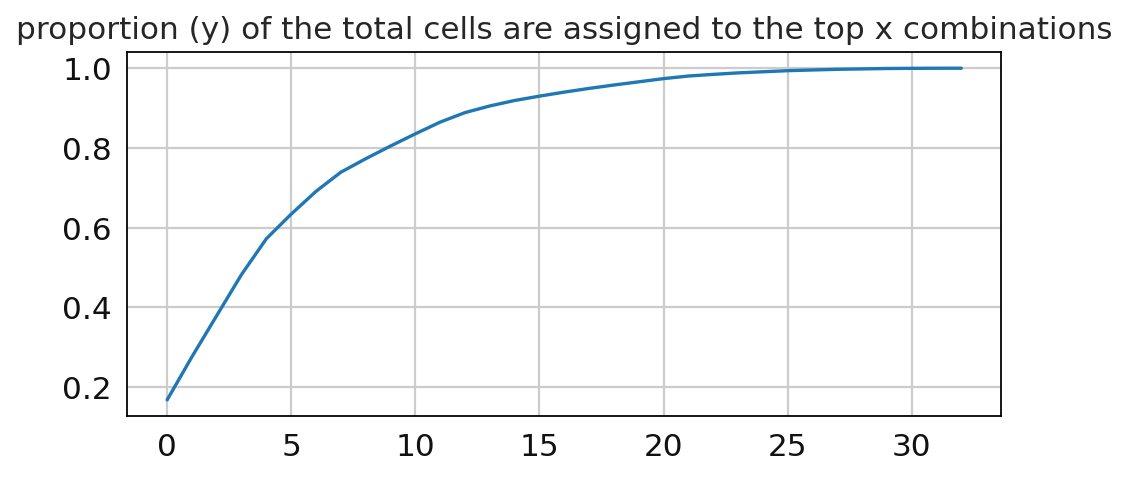

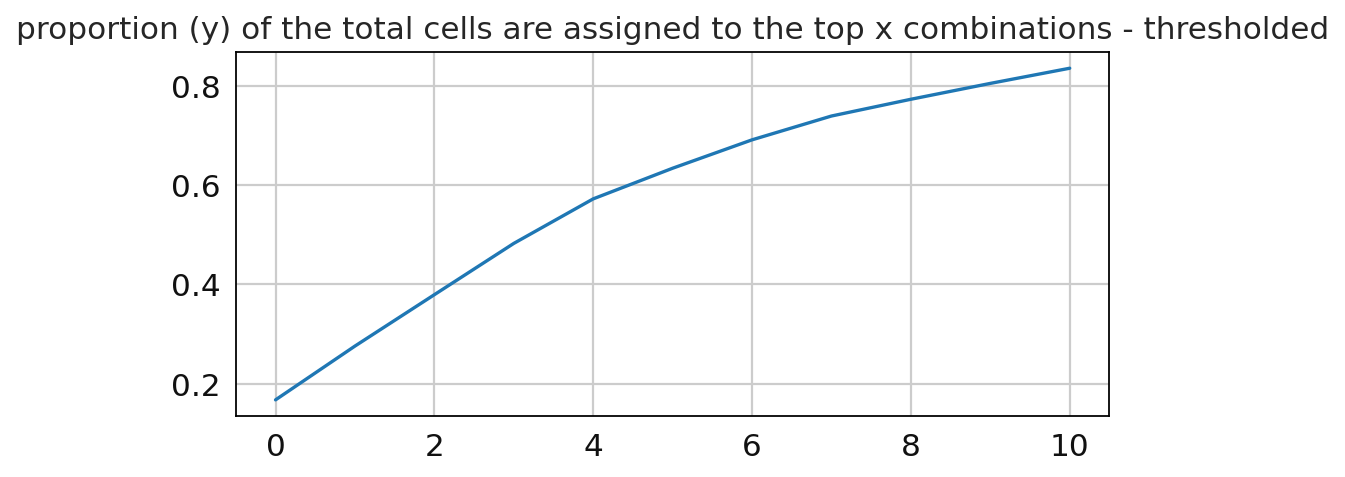

In [16]:
cnmap_dict_tonsillitis = sp.tl.cn_map_ad(
    adata = adata_tonsillitis, # adata object
    cn_col = "CN_k20_n6",# column with CNs
    palette = None, # color dictionary
    unique_region = 'region_num',# column with unique regions
    k = 70, # number of neighbors
    X='x', Y='y',  # coordinates
    threshold = 0.85, # threshold for percentage of cells in CN
    per_keep_thres = 0.85,) # threshold for percentage of cells in CN

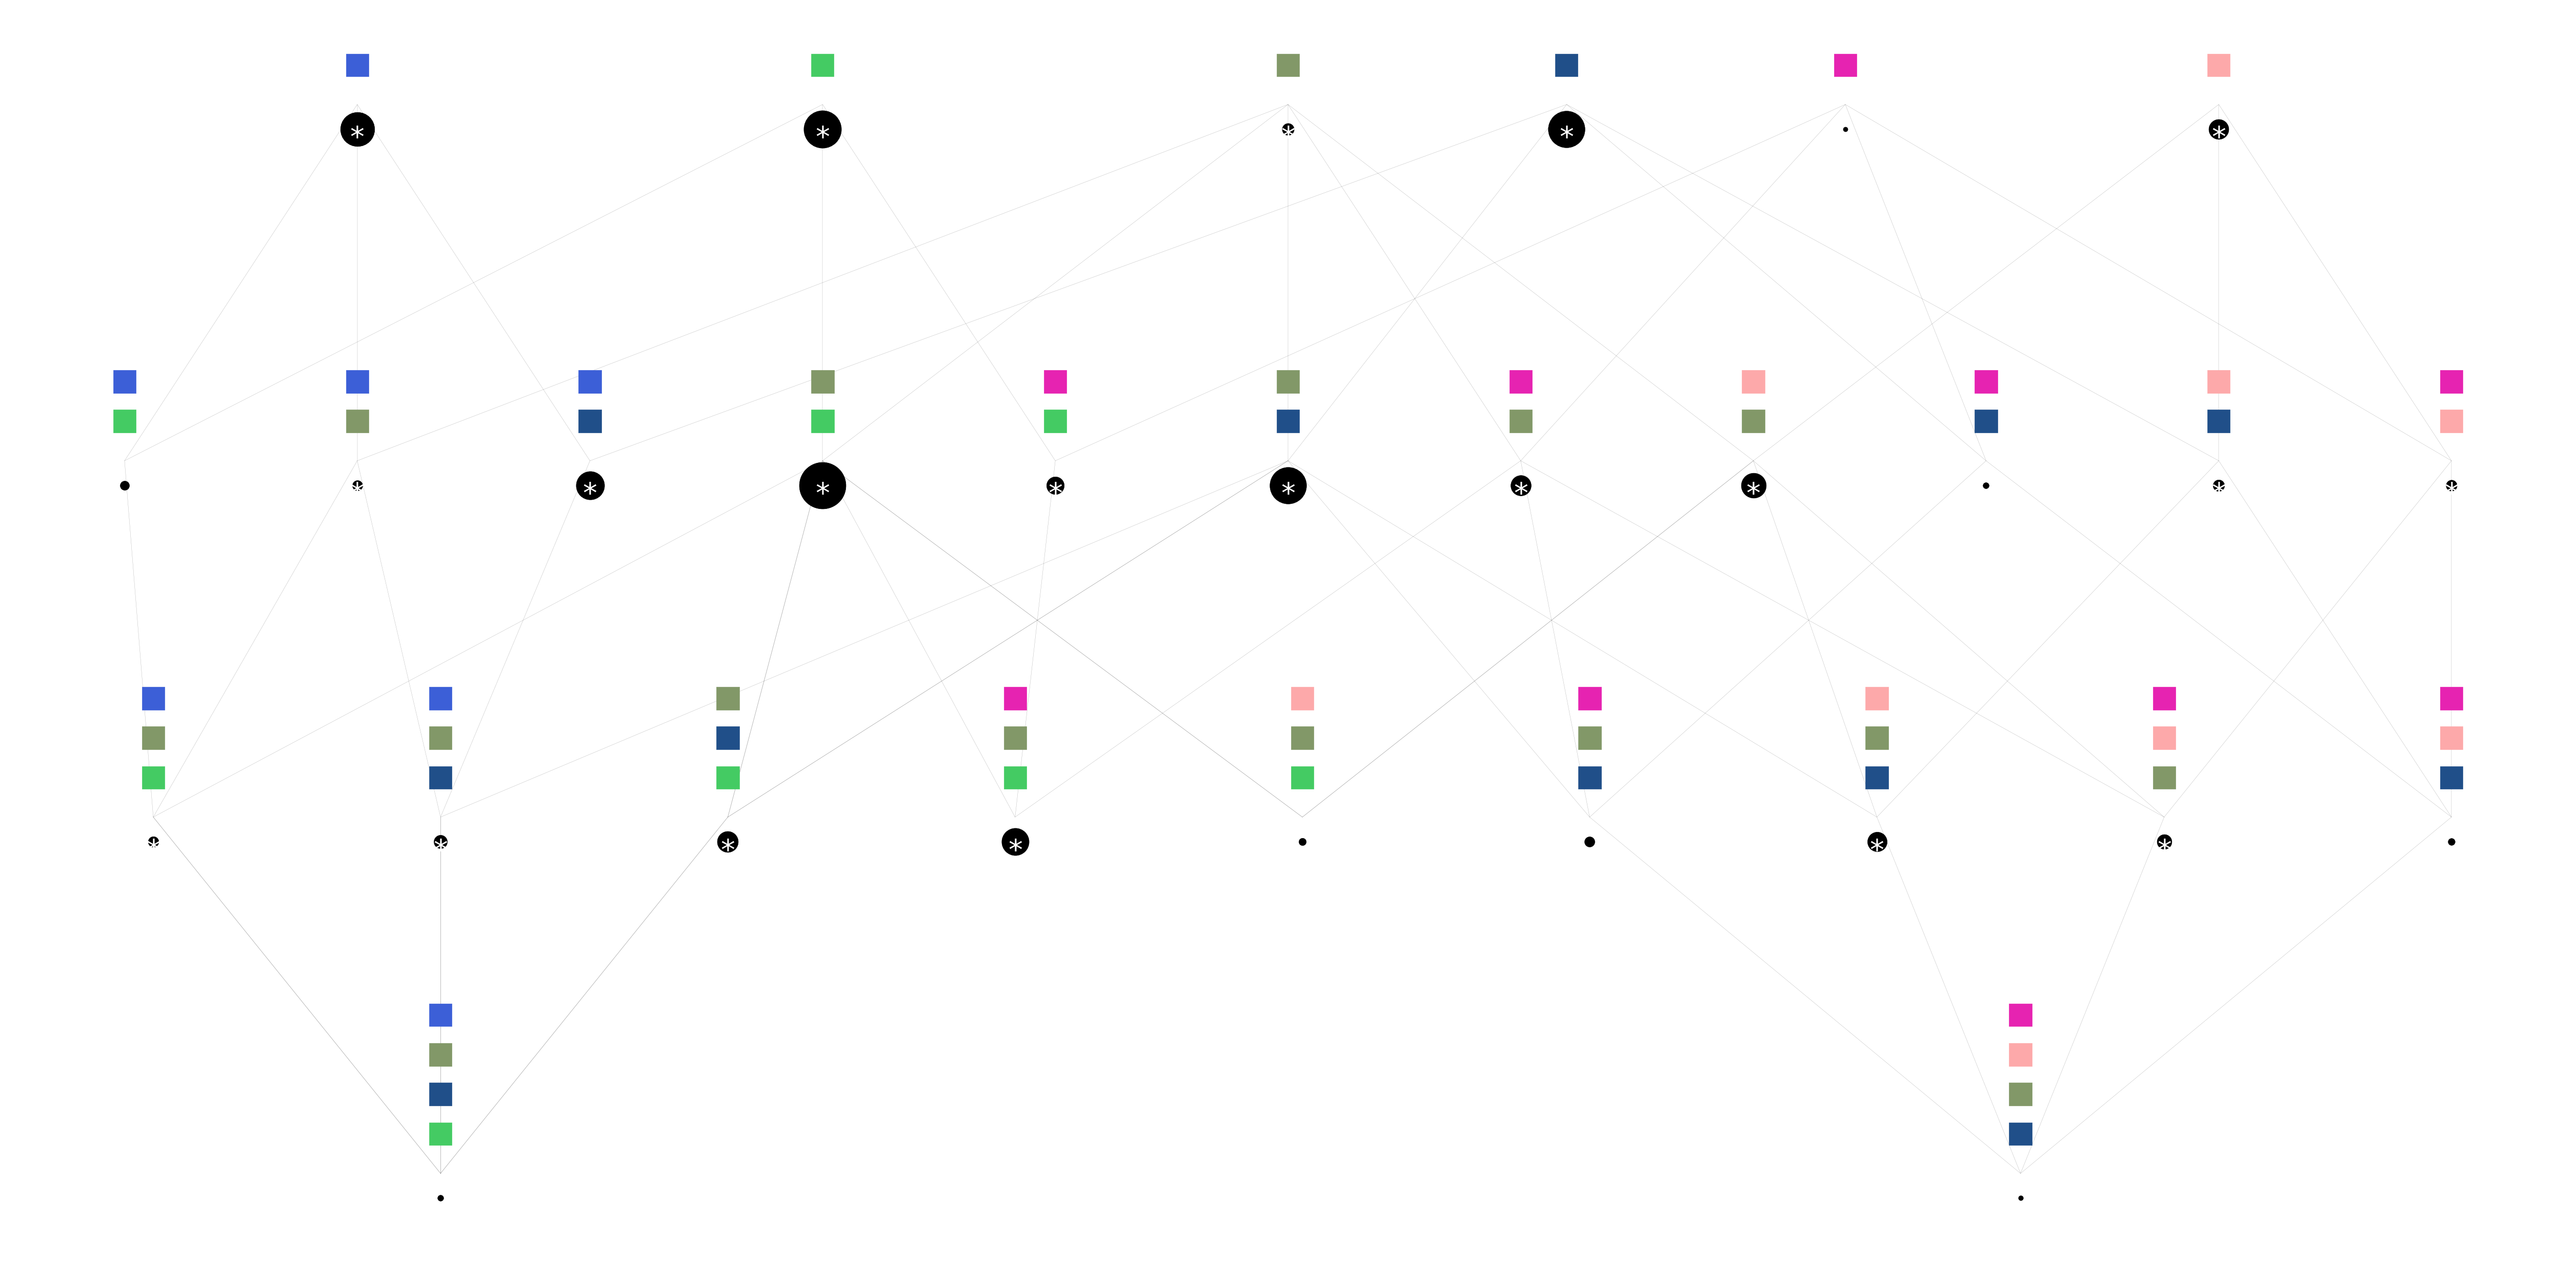

In [17]:
sp.pl.cn_map(
    cnmap_dict = cnmap_dict_tonsillitis,
    adata = adata_tonsillitis,
    cn_col = "CN_k20_n6",
    palette = None,
    figsize=(40, 20),
    savefig=False,
    output_fname = "",
    output_dir= output_dir)